In [1]:
!pip install scipy==1.2.2

     |████████████████████████████████| 24.8 MB 39 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf 
import os 
import numpy as np 
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Input, Flatten, AveragePooling2D, Add
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.datasets import cifar10 
from tensorflow.keras.datasets import fashion_mnist

# to resize fashion MNIST from 28x28 to 32x32 
from tqdm import tqdm
from scipy import misc

In [4]:
batch_size=32 
epochs=100 
num_classes=10 
depth=20 

In [5]:
model_type = 'ResNet%d' % (depth)

In [6]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() 

4423680/4422102 [==============================] - 0s 0us/step


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """Entry point for launching an IPython kernel.
60000it [00:04, 14735.23it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.
10000it [00:00, 15485.20it/s]


(32, 32)


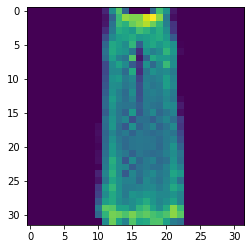

In [7]:
x_train = np.array([misc.imresize(x, (32, 32)).astype(float) for x in tqdm(iter(x_train))])
x_train = x_train[:, :, :, np.newaxis]

x_test = np.array([misc.imresize(x, (32, 32)).astype(float) for x in tqdm(iter(x_test))])
x_test = x_test[:, :, :, np.newaxis]

x_train = x_train/255 
x_test = x_test/255 

idx = np.random.randint(0, 59999)

img = x_train[idx].squeeze()

plt.imshow(img)
print(img.shape)


y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes) 
input_shape=x_train.shape[1:]

In [8]:
def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=True, conv_first=True):
    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')
    x = inputs 
    if conv_first:
        x = conv(x) 
        if batch_normalization:
            x = BatchNormalization()(x) 
        if activation is not None:
            x = Activation(activation)(x)

    else: 
        if batch_normalization:
            x = BatchNormalization()(x) 
        if activation is not None:
            x = Activation(activation)(x) 
        x = conv(x) 
    return x

In [9]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2)%6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20,32, 44 in [a])')

    # model definition 
    num_filters = 16 
    num_res_blocks = int((depth-2)/6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs) 

    ## instantiate the stack of residual units 
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1 
            if stack > 0 and res_block ==0: # first layer but not first stack 
                strides = 2 # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0: # first layer but not first stack 
                # linear projection residual shortcut connection to match changed dimes 
                x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1, strides=strides, activation=None, batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = Activation('relu')(x) 
            x = Dropout(rate=0.25)(x) 
        num_filters *= 2 

    # Add classifier on top 
    # v1 does not use BN after last shortcut connection to match changed dims 
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x) 

    outputs = Dense(num_classes, activation='softmax')(y)

    # Instantiate model 
    model = Model(inputs=inputs, outputs=outputs)
    return model          

In [10]:
model = resnet_v1(input_shape=input_shape, depth=depth)

In [11]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [12]:
model.summary() 
print(model_type)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
save_dir = os.path.join(os.getcwd(), 'saved_models') 
model_name = 'fashionMNIST_%s_model.{epoch:03d}.h5'%model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [14]:
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=2, save_best_only=True)

In [15]:
callbacks = [checkpoint] 

In [16]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks)

Epoch 1/100
1500/1500 [==============================] - 52s 12ms/step - loss: 0.6821 - accuracy: 0.7485 - val_loss: 0.4970 - val_accuracy: 0.8155

Epoch 00001: val_accuracy improved from -inf to 0.81550, saving model to /content/saved_models/fashionMNIST_ResNet20_model.001.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
1500/1500 [==============================] - 19s 13ms/step - loss: 0.4132 - accuracy: 0.8511 - val_loss: 0.4025 - val_accuracy: 0.8569

Epoch 00002: val_accuracy improved from 0.81550 to 0.85692, saving model to /content/saved_models/fashionMNIST_ResNet20_model.002.h5
Epoch 3/100
1500/1500 [==============================] - 19s 13ms/step - loss: 0.3502 - accuracy: 0.8744 - val_loss: 0.3098 - val_accuracy: 0.8892

Epoch 00003: val_accuracy improved from 0.85692 to 0.88917, saving model to /content/saved_models/fashionMNIST_ResNet20_model.003.h5
Epoch 4/100
1500/1500 [==============================] - 19s 12ms/step - loss: 0.3154 - accuracy: 0.8870 - val_loss: 0.2659 - val_accuracy: 0.9022

Epoch 00004: val_accuracy improved from 0.88917 to 0.90217, saving model to /content/saved_models/fashionMNIST_ResNet20_model.004.h5
Epoch 5/100
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2947 - accuracy: 0.8927 - val_loss: 0.3223 - val_accuracy: 0.8848

Epoch 000

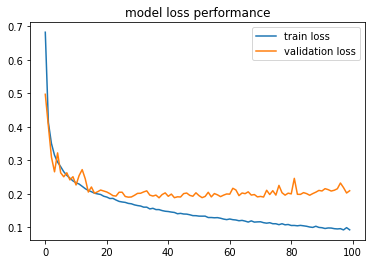

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss performance')
plt.legend(['train loss', 'validation loss'])
plt.show()

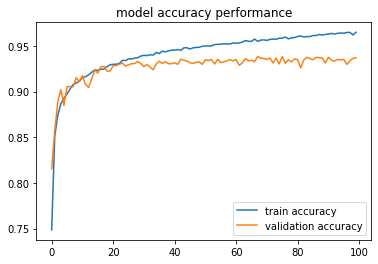

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy performance')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

In [19]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.2172 - accuracy: 0.9362


[0.2172386646270752, 0.9362000226974487]

In [ ]:
# https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0
# http://www.pabloruizruiz10.com/resources/CNNs/ResNet-PyTorch.html 
# https://github.com/shoji9x9/Fashion-MNIST-By-ResNet/blob/master/Fashion-MNIST-by-ResNet-50.ipynb